In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load the pipeline
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

In [ ]:
# 2. Load & prep your artifact-ridden image
init_image = Image.open("/content/3dgs_result.jpg").convert("RGB")
# SD likes multiples of 64px:
# init_image = init_image.resize((768, 512))
H, W =  init_image.height, init_image.width

# 3. Define a “clean” prompt (and optional negative prompt)
prompt = "A sharp, high-resolution photo of a road scene, no blur, no motion artifacts"
negative_prompt = "blurry, warped, noisy, distorted, painterly"

# 4. Run Img2Img with low strength → denoise just enough
with torch.autocast("cuda"):
    out = pipe(
        prompt="A sharp, high-resolution photo of a road scene, no blur, no motion artifacts",
        negative_prompt="blurry, warped, noisy, distorted, painterly",
        image=init_image,         # your up→down resized image or full-res frame
        strength=0.30,            # softer touch than 0.35
        guidance_scale=7.5,       # a bit stronger than 7.0 to enforce “no blur”
        num_inference_steps=60,   # 50–60 steps gives crisp detail without excessive compute
        generator=torch.manual_seed(42),
        height=H,
        width=W,
    )
clean_img = out.images[0]

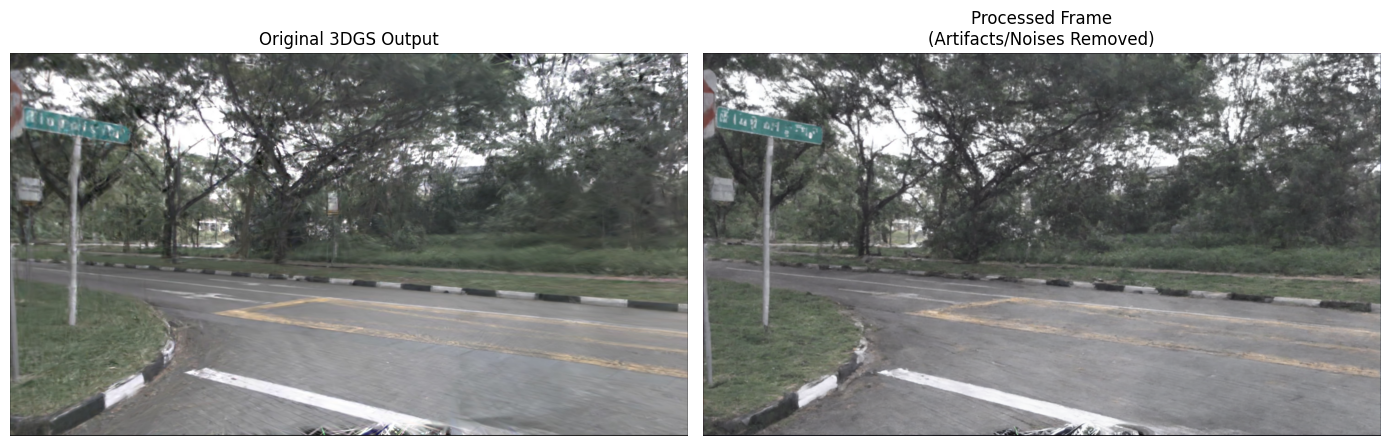

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Original
ax1.imshow(init_image)
ax1.set_title("Original 3DGS Output", fontsize=12)
ax1.axis("off")

# Cleaned / Inpainted
ax2.imshow(clean_img)
ax2.set_title("Processed Frame\n(Artifacts/Noises Removed)", fontsize=12)
ax2.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# 1. Optionally bump up the figure size if you want more pixels overall
fig.set_size_inches(16, 8)   # width=16", height=8" (at your DPI)

# 2. Save to disk with high DPI
out_path = "/content/comparison_highres.png"
fig.savefig(
    out_path,
    dpi=300,                   # 300 dpi → (16 in × 300 dpi) ≈ 4800 px wide
    bbox_inches="tight",       # crop extra white
    pad_inches=0.1
)